# 機器學習實作練習
https://www.kaggle.com/t/b3a5bc4baa8157dfdacbc114f3a97d8c

2022/12/6-9

## 要練習的目標

* 資料處裡與特徵工程
* 機器學習演算法
* 評估指標

如果還有時間，不妨試著使用其他演算法建模，並計算除了準確率以外的指標，像是F1-score、Recall、Precision，再對不同模型結果進行客觀的比較。

In [1011]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import pathlib
import pandas as pd
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from pandas_profiling import ProfileReport

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 1. 讀取資料

* PassengerId - 每位旅客的編號，格式為`xxxx_yy`，`xxxx`代表該旅客的團體，`yy`代表該旅客屬於團體的第幾位。
* HomePlanet - 該旅客來自哪一個星球。
* CryoSleep - 一種深層睡眠設備，若為`True`則該乘客在旅程中都會被固定在其艙位內。
* Cabin - 艙位編號，格式為`層/號碼/側`，`側`可能是`P`或`S`，`P`代表左舷、`S`代表右舷。
* Destination - 該乘客的目的地。
* Age -該乘客的年齡。
* VIP - 該乘客是否為VIP。
* RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - 該乘客於這些奢華服務上的消費金額。
* Name - 乘客姓名。
* Transported - 該乘客是否被傳送到另一個維度，是這個任務中需預測的目標。

In [1012]:
df_train = pd.read_csv(f'./train.csv', header = 0)
df_test = pd.read_csv(f'./test.csv', header = 0)

print(df_train.shape)
print(df_test.shape)

(7000, 14)
(1693, 13)


In [1013]:
df_train.sample(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
6873,7890_02,Earth,True,G/1273/S,55 Cancri e,17.0,False,0.0,0.0,0.0,0.0,0.0,Edgary Reenez,True
4494,2697_01,Mars,False,D/91/S,TRAPPIST-1e,27.0,NaN,1893.0,487.0,4.0,0.0,0.0,Pank Pimne,False
5167,6020_05,Earth,False,F/1242/P,55 Cancri e,34.0,False,0.0,968.0,273.0,NaN,283.0,Mabela Hanner,False
1381,2595_03,Mars,False,D/76/P,TRAPPIST-1e,28.0,False,938.0,61.0,0.0,53.0,4.0,Res Fle,False
6940,8554_01,Earth,False,E/547/P,PSO J318.5-22,58.0,False,487.0,0.0,195.0,0.0,7.0,Britta Valezaley,True


In [1014]:
df_test

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent
1,0007_01,Earth,False,F/3/S,TRAPPIST-1e,35.0,False,0.0,785.0,17.0,216.0,0.0,Andona Beston
2,0008_03,Europa,False,B/1/P,55 Cancri e,45.0,False,39.0,7295.0,589.0,110.0,124.0,Wezena Flatic
3,0017_01,Earth,False,G/0/P,TRAPPIST-1e,0.0,False,0.0,0.0,0.0,0.0,0.0,Lyde Brighttt
4,0017_02,Earth,False,F/6/P,55 Cancri e,14.0,False,412.0,0.0,1.0,0.0,679.0,Philda Brighttt
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1688,9227_01,Earth,True,G/1498/P,TRAPPIST-1e,7.0,False,0.0,0.0,0.0,0.0,0.0,Glendy Hinglendez
1689,9239_01,Mars,False,E/593/P,TRAPPIST-1e,14.0,False,2.0,0.0,918.0,128.0,0.0,Per Minen
1690,9252_02,Europa,True,B/301/P,55 Cancri e,19.0,False,0.0,0.0,0.0,0.0,0.0,Muonon Stranbeate
1691,9256_01,Earth,True,G/1494/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,0.0,Darley Franton


此步驟我們會用[pandas.DataFrame.isna](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.isna.html)檢視各欄位的缺失值，再進行補0或補平均值等等的處理。

In [1015]:
df = pd.concat([df_train, df_test], axis = 0).copy()
print(df.isna().sum() / df.shape[0])

PassengerId     0.000000
HomePlanet      0.023122
CryoSleep       0.024963
Cabin           0.022892
Destination     0.020936
Age             0.020591
VIP             0.023352
RoomService     0.020821
FoodCourt       0.021051
ShoppingMall    0.023927
Spa             0.021051
VRDeck          0.021627
Name            0.023007
Transported     0.194754
dtype: float64


[pandas.DataFrame.info](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.info.html)可檢視每個欄位的Null值及其資料類別，結果顯示這份資料是不需要補值，資料類型也都能被模型使用。但如果今天拿到的資料有缺值或資料類型不合規定，就必須在這步驟處理完成。

[pandas.DataFrame.describe](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html)可以檢視各欄位的統計資料，有助於了解極端值的數量。

In [1016]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8693 entries, 0 to 1692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   7000 non-null   object 
dtypes: float64(6), object(8)
memory usage: 1018.7+ KB


In [1017]:
df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


## 2. EDA

In [1018]:
df.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

VIP    Transported
False  False          3273
       True           3414
True   False           100
       True             56
Name: VIP, dtype: int64


<AxesSubplot:xlabel='VIP'>

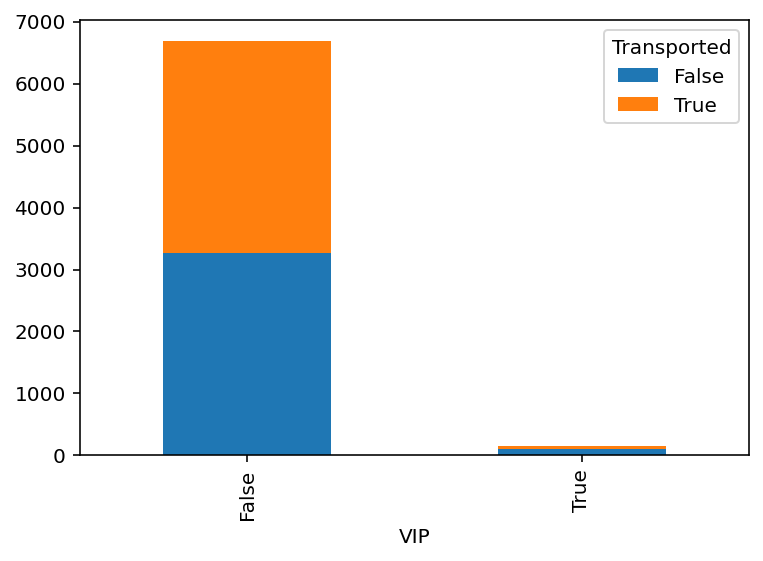

In [1019]:
print(df_train.groupby(['VIP', 'Transported'])['VIP'].count())
df1 = df_train.groupby(['VIP', 'Transported'])['VIP'].count().unstack()
df1.plot(kind = 'bar', stacked = True)

<bound method Series.unstack of HomePlanet  Transported
Earth       False          2145
            True           1592
Europa      False           581
            True           1126
Mars        False           643
            True            752
Name: HomePlanet, dtype: int64>


<AxesSubplot:xlabel='HomePlanet'>

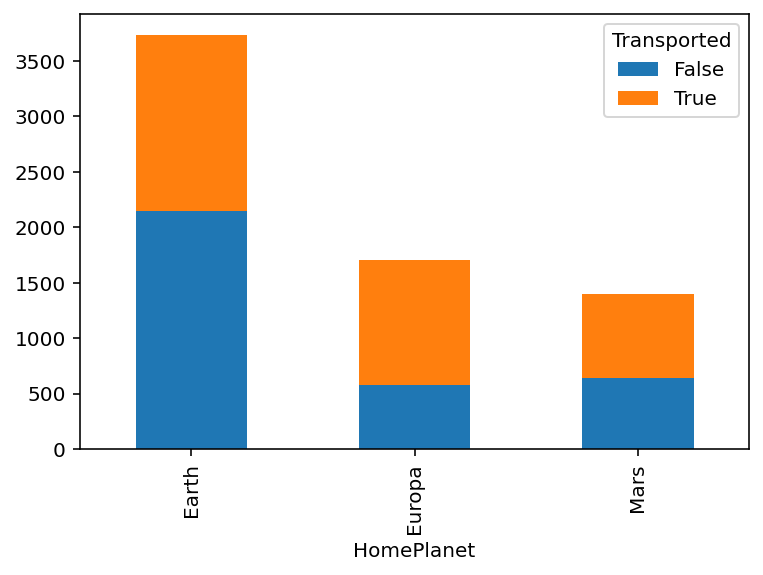

In [1020]:
print(df_train.groupby(['HomePlanet', 'Transported'])['HomePlanet'].count().unstack)
df1 = df_train.groupby(['HomePlanet', 'Transported'])['HomePlanet'].count().unstack()
df1.plot(kind = 'bar', stacked = True)

<bound method Series.unstack of Destination    Transported
55 Cancri e    False           575
               True            886
PSO J318.5-22  False           316
               True            325
TRAPPIST-1e    False          2491
               True           2264
Name: Destination, dtype: int64>


<AxesSubplot:xlabel='Destination'>

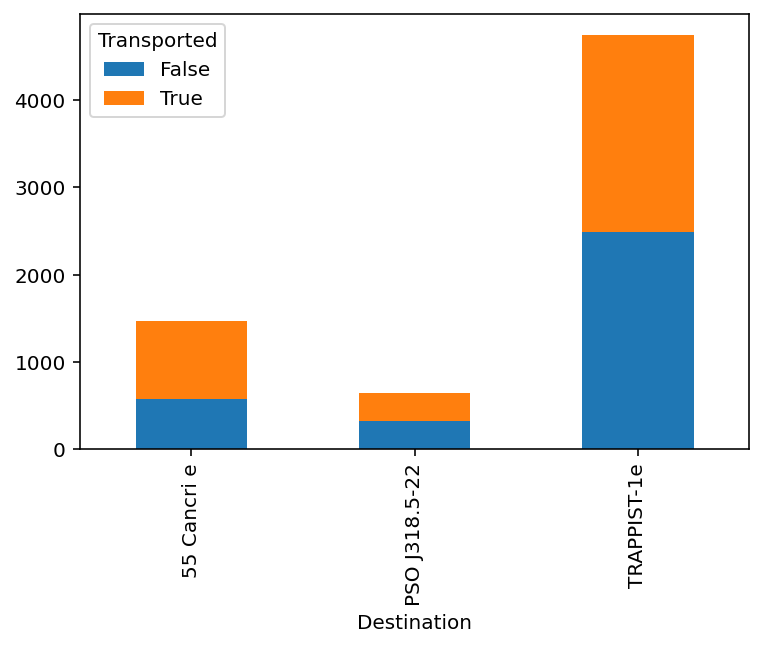

In [1021]:
print(df_train.groupby(['Destination', 'Transported'])['Destination'].count().unstack)
df1 = df_train.groupby(['Destination', 'Transported'])['Destination'].count().unstack()
df1.plot(kind = 'bar', stacked = True)

<bound method Series.unstack of CryoSleep  Transported
False      False          2904
           True           1464
True       False           454
           True           2003
Name: CryoSleep, dtype: int64>


<AxesSubplot:xlabel='CryoSleep'>

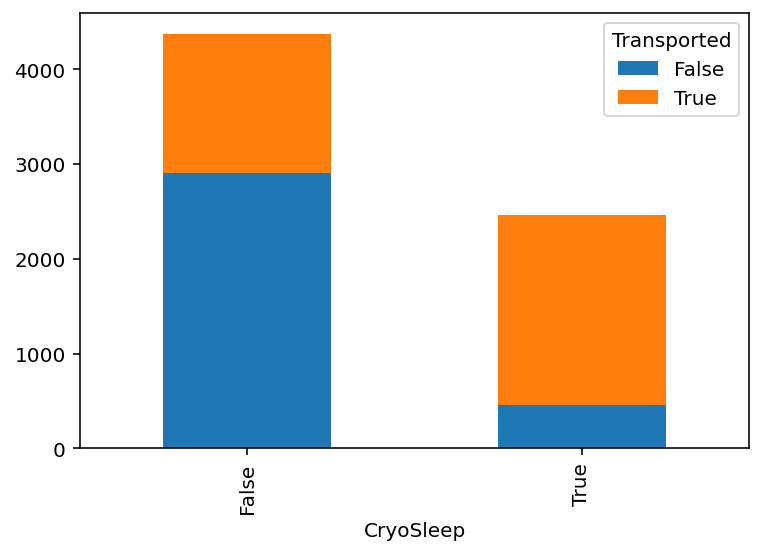

In [1022]:
print(df_train.groupby(['CryoSleep', 'Transported'])['CryoSleep'].count().unstack)
df1 = df_train.groupby(['CryoSleep', 'Transported'])['CryoSleep'].count().unstack()
df1.plot(kind = 'bar', stacked = True)

## 3. 前處理

### 3.1 映射

[pandas.Series.map](https://pandas.pydata.org/docs/reference/api/pandas.Series.map.html)可將指定的值進行映射。

In [1023]:
df['Transported'] = df['Transported'].map({True: 1, False: 0})

In [1024]:
df.head(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,1651_03,Earth,True,G/266/P,PSO J318.5-22,0.0,False,0.0,0.0,0.0,0.0,0.0,Deanny Wonglasquez,1.0
1,1058_01,Earth,False,F/201/S,TRAPPIST-1e,19.0,False,0.0,0.0,27.0,53.0,677.0,Keithy Ingston,0.0
2,5783_01,Earth,False,F/1201/P,55 Cancri e,43.0,False,0.0,1197.0,0.0,223.0,1.0,Alendy Scottuez,1.0
3,5931_01,Europa,False,A/56/P,55 Cancri e,39.0,False,0.0,0.0,0.0,1854.0,171.0,Alcoran Clugeammy,0.0
4,3512_01,Earth,False,F/662/S,55 Cancri e,28.0,False,1.0,0.0,857.0,0.0,0.0,Wallyn Holcompson,0.0


### 3.2 編碼

[pandas.get_dummies](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html)可以直接將類別特徵進行One-hot編碼。

In [1025]:
for features in ['HomePlanet']:
    df = pd.get_dummies(df, columns = [features])
    
for features in ['CryoSleep', 'VIP']:
    df[features] = df[features].map({True: 1, False: 0})

In [1026]:
df

,PassengerId,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars
0,1651_03,1.0,G/266/P,PSO J318.5-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Deanny Wonglasquez,1.0,1,0,0
1,1058_01,0.0,F/201/S,TRAPPIST-1e,19.0,0.0,0.0,0.0,27.0,53.0,677.0,Keithy Ingston,0.0,1,0,0
2,5783_01,0.0,F/1201/P,55 Cancri e,43.0,0.0,0.0,1197.0,0.0,223.0,1.0,Alendy Scottuez,1.0,1,0,0
3,5931_01,0.0,A/56/P,55 Cancri e,39.0,0.0,0.0,0.0,0.0,1854.0,171.0,Alcoran Clugeammy,0.0,0,1,0
4,3512_01,0.0,F/662/S,55 Cancri e,28.0,0.0,1.0,0.0,857.0,0.0,0.0,Wallyn Holcompson,0.0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1688,9227_01,1.0,G/1498/P,TRAPPIST-1e,7.0,0.0,0.0,0.0,0.0,0.0,0.0,Glendy Hinglendez,NaN,1,0,0
1689,9239_01,0.0,E/593/P,TRAPPIST-1e,14.0,0.0,2.0,0.0,918.0,128.0,0.0,Per Minen,NaN,0,0,1
1690,9252_02,1.0,B/301/P,55 Cancri e,19.0,0.0,0.0,0.0,0.0,0.0,0.0,Muonon Stranbeate,NaN,0,1,0
1691,9256_01,1.0,G/1494/S,TRAPPIST-1e,28.0,0.0,0.0,0.0,0.0,0.0,0.0,Darley Franton,NaN,1,0,0


[pandas.DataFrame.apply](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html)是很實用的功能，可以將一個函數應用到DataFrame的某一個軸，例如`axis = 0`或`axis = 1`。

[pandas.DataFrame.groupby](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html)能以Series作為標準，將DataFrame進行分組。

[pandas.DataFrame.transform](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.transform.html)將指定的函數應用於DataFrame上。

In [1027]:
df['Group'] = df.apply(lambda row: row['PassengerId'][0:4], axis = 1)
df['Number'] = df.apply(lambda row: int(row['PassengerId'][5:7]), axis = 1)
df['FamilySize'] = df.groupby(['Group'])['Number'].transform(np.sum)

In [1028]:
df

,PassengerId,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Group,Number,FamilySize
0,1651_03,1.0,G/266/P,PSO J318.5-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Deanny Wonglasquez,1.0,1,0,0,1651,3,6
1,1058_01,0.0,F/201/S,TRAPPIST-1e,19.0,0.0,0.0,0.0,27.0,53.0,677.0,Keithy Ingston,0.0,1,0,0,1058,1,1
2,5783_01,0.0,F/1201/P,55 Cancri e,43.0,0.0,0.0,1197.0,0.0,223.0,1.0,Alendy Scottuez,1.0,1,0,0,5783,1,1
3,5931_01,0.0,A/56/P,55 Cancri e,39.0,0.0,0.0,0.0,0.0,1854.0,171.0,Alcoran Clugeammy,0.0,0,1,0,5931,1,1
4,3512_01,0.0,F/662/S,55 Cancri e,28.0,0.0,1.0,0.0,857.0,0.0,0.0,Wallyn Holcompson,0.0,1,0,0,3512,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1688,9227_01,1.0,G/1498/P,TRAPPIST-1e,7.0,0.0,0.0,0.0,0.0,0.0,0.0,Glendy Hinglendez,NaN,1,0,0,9227,1,15
1689,9239_01,0.0,E/593/P,TRAPPIST-1e,14.0,0.0,2.0,0.0,918.0,128.0,0.0,Per Minen,NaN,0,0,1,9239,1,1
1690,9252_02,1.0,B/301/P,55 Cancri e,19.0,0.0,0.0,0.0,0.0,0.0,0.0,Muonon Stranbeate,NaN,0,1,0,9252,2,3
1691,9256_01,1.0,G/1494/S,TRAPPIST-1e,28.0,0.0,0.0,0.0,0.0,0.0,0.0,Darley Franton,NaN,1,0,0,9256,1,1


In [1029]:
df['CabinName'] = df['Cabin'].str.split(pat = '/', expand = True)[0]
df['Side'] = df['Cabin'].str.split(pat = '/', expand = True)[2]

# df['CabinName'] = df['CabinName'].map({
#     'A': 0,
#     'B': 1,
#     'C': 1,
#     'D': 0,
#     'E': 0,
#     'F': 0,
#     'G': 0,
#     'T': 0
# })

df['Side'] = df['Side'].map({
    'P': 0,
    'S': 1,
})

# df['Destination'] = df['Destination'].map({
#     '55 Cancri e': 1,
#     'PSO J318.5-22': 0,
#     'TRAPPIST-1e': 0
# })

In [1030]:
df = df.drop(['Destination'], axis = 1)

<AxesSubplot:xlabel='CabinName'>

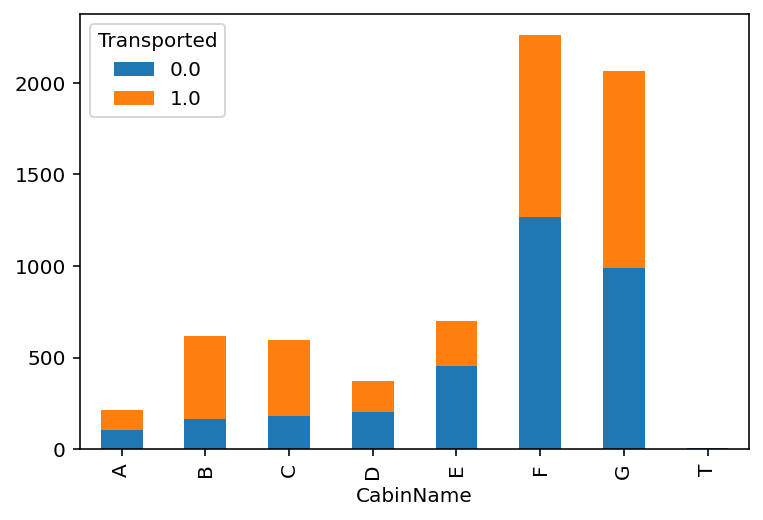

In [1031]:
# print(df.iloc[:df_train.shape[0], :].groupby(['CabinName', 'Transported'])['CabinName'].count().unstack)
df1 = df.iloc[:df_train.shape[0], :].groupby(['CabinName', 'Transported'])['CabinName'].count().unstack()
df1.plot(kind = 'bar', stacked = True)

In [1032]:
# df1 = df.iloc[:df_train.shape[0], :].groupby(['FamilySize', 'Transported'])['FamilySize'].count().unstack()
# df1.plot(kind = 'bar', stacked = True)

In [1033]:
# print(df.iloc[:df_train.shape[0], :].groupby(['Number', 'Transported'])['Number'].count().unstack)

# df1 = df.iloc[:df_train.shape[0], :].groupby(['Number', 'Transported'])['Number'].count().unstack()
# df1.plot(kind = 'bar', stacked = True)

<AxesSubplot:xlabel='Side'>

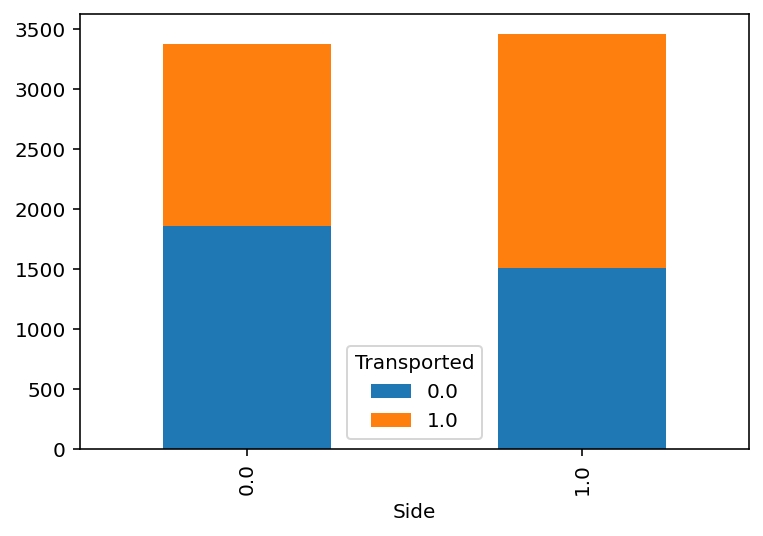

In [1034]:
df1 = df.iloc[:df_train.shape[0], :].groupby(['Side', 'Transported'])['Side'].count().unstack()
df1.plot(kind = 'bar', stacked = True)

In [1035]:
df = pd.get_dummies(df, columns = ['CabinName'])

In [1036]:
df = df.drop(['PassengerId', 'Group', 'Number', 'Name', 'Cabin'], axis = 1)
features = df.columns.to_list()

In [1037]:
df

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,HomePlanet_Earth,...,FamilySize,Side,CabinName_A,CabinName_B,CabinName_C,CabinName_D,CabinName_E,CabinName_F,CabinName_G,CabinName_T
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,...,6,0.0,0,0,0,0,0,0,1,0
1,0.0,19.0,0.0,0.0,0.0,27.0,53.0,677.0,0.0,1,...,1,1.0,0,0,0,0,0,1,0,0
2,0.0,43.0,0.0,0.0,1197.0,0.0,223.0,1.0,1.0,1,...,1,0.0,0,0,0,0,0,1,0,0
3,0.0,39.0,0.0,0.0,0.0,0.0,1854.0,171.0,0.0,0,...,1,0.0,1,0,0,0,0,0,0,0
4,0.0,28.0,0.0,1.0,0.0,857.0,0.0,0.0,0.0,1,...,1,1.0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1688,1.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1,...,15,0.0,0,0,0,0,0,0,1,0
1689,0.0,14.0,0.0,2.0,0.0,918.0,128.0,0.0,NaN,0,...,1,0.0,0,0,0,0,1,0,0,0
1690,1.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,...,3,0.0,0,1,0,0,0,0,0,0
1691,1.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1,...,1,1.0,0,0,0,0,0,0,1,0


In [1038]:
num_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Side']
cat_features = ['VIP', 'CryoSleep', 'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars']

### 3.3 補缺值

缺值除了補0，也可以使用[sklearn.impute.KNNImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html)，將樣本以其最近的`k`個相鄰樣本的平均值填補缺值，`k`值可自訂。

這個做法的概念，類似於機器學習中著名的演算法[k-Nearest Neighbor (k-NN)](https://aiec.nccu.edu.tw/ai-column/26)，概念就是「近朱者赤，近墨者黑」，距離哪個類別的樣本最近，就被分到哪一個類別。

In [1039]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors = 1)
df[num_features] = imputer.fit_transform(df[num_features])

In [1040]:
for features in cat_features:
    df[features] = df[features].fillna(value = df[features].mode()[0])

In [1041]:
df

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,HomePlanet_Earth,...,FamilySize,Side,CabinName_A,CabinName_B,CabinName_C,CabinName_D,CabinName_E,CabinName_F,CabinName_G,CabinName_T
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,...,6,0.0,0,0,0,0,0,0,1,0
1,0.0,19.0,0.0,0.0,0.0,27.0,53.0,677.0,0.0,1,...,1,1.0,0,0,0,0,0,1,0,0
2,0.0,43.0,0.0,0.0,1197.0,0.0,223.0,1.0,1.0,1,...,1,0.0,0,0,0,0,0,1,0,0
3,0.0,39.0,0.0,0.0,0.0,0.0,1854.0,171.0,0.0,0,...,1,0.0,1,0,0,0,0,0,0,0
4,0.0,28.0,0.0,1.0,0.0,857.0,0.0,0.0,0.0,1,...,1,1.0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1688,1.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1,...,15,0.0,0,0,0,0,0,0,1,0
1689,0.0,14.0,0.0,2.0,0.0,918.0,128.0,0.0,NaN,0,...,1,0.0,0,0,0,0,1,0,0,0
1690,1.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,...,3,0.0,0,1,0,0,0,0,0,0
1691,1.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1,...,1,1.0,0,0,0,0,0,0,1,0


In [1042]:
df.isna().sum()

CryoSleep               0
Age                     0
VIP                     0
RoomService             0
FoodCourt               0
ShoppingMall            0
Spa                     0
VRDeck                  0
Transported          1693
HomePlanet_Earth        0
HomePlanet_Europa       0
HomePlanet_Mars         0
FamilySize              0
Side                    0
CabinName_A             0
CabinName_B             0
CabinName_C             0
CabinName_D             0
CabinName_E             0
CabinName_F             0
CabinName_G             0
CabinName_T             0
dtype: int64

### 3.4 分割資料集

In [1044]:
X_train = df.iloc[:df_train.shape[0], :]
Y_train = X_train['Transported']

X_train = X_train.drop(['Transported'], axis = 1)

X_test = df.iloc[df_train.shape[0]:, :]
X_test = X_test.drop(['Transported'], axis = 1)

### 3.5 標準化
使用[sklearn.preprocessing](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing)裡面的[StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)來完成資料標準化，其計算方式為：
$\begin{equation} Z = \frac{X - \mu}{\sigma} \end{equation}$

$Z$：標準化後特徵、$X$：原始特徵、$\mu$：平均值、$\sigma$：標準差。

In [544]:
# from sklearn.preprocessing import StandardScaler

# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)

## 4. 模型訓練、最佳化

模型訓練時，我們希望能在過程中評估效能，同時避免發生過擬合，因此需進行交叉驗證，最常見的是5折、10折交叉驗證。

[sklearn.linear_model](https://scikit-learn.org/stable/modules/linear_model.html)中有很多不同線性模型，用來建立模型物件。

[sklearn.model_selection.RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)用來進行隨機搜尋法，尋找出最佳超參數組合。

[sklearn.model_selection.cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score)可方便我們進行交叉驗證並計算分數。

In [1056]:
from sklearn.model_selection import cross_validate, ShuffleSplit, RandomizedSearchCV
from xgboost import XGBClassifier

distributions = {
    'n_estimators'    : np.arange(100, 150, 10),
    'max_depth'       : np.arange(15, 60, 1),
    'learning_rate'   : np.array([0.1, 0.2, 0.3, 0.4, 0.5]),
    'gamma'           : np.linspace(0.1, 1.0, num = 10),
    'colsample_bytree': np.linspace(0.7, 1.0, num = 7),
    'subsample'       : np.linspace(0.7, 1.0, num = 7)
}

cv = ShuffleSplit(n_splits = 5, random_state = 999)

XGBmodel = XGBClassifier(
    objective = 'binary:logistic',
    n_jobs = -1
)

clf = RandomizedSearchCV(
    XGBmodel, 
    distributions, 
    random_state = 6, 
    cv = cv, 
    verbose = 1,
    n_iter = 10,
    scoring = 'accuracy'
)

search = clf.fit(X_train, Y_train)

print(search.best_params_)
print(search.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'subsample': 0.7999999999999999, 'n_estimators': 100, 'max_depth': 26, 'learning_rate': 0.1, 'gamma': 0.4, 'colsample_bytree': 0.7999999999999999}
0.7868571428571429


In [1059]:
XGBmodel = search.best_estimator_

import time 
begin = time.time()

XGBmodel.fit(X_train, Y_train)

timelapse = time.time() - begin

print(f'Training time: {timelapse:.4f} seconds.')

Training time: 1.1600 seconds.


## 5. 預測測試資料

對測試集進行預測，並依格式產生要繳交的檔案。

最後，記得將預測結果上傳到Kaggle競賽中的繳交區，上傳前務必再確認是否每筆資料都有預測到，以及格式是否符合規定。

In [1062]:
Y_test = XGBmodel.predict(X_test)

In [1063]:
submission = pd.read_csv(f'./submission_example.csv')
submission['Transported'] = Y_test
submission['Transported'] = submission['Transported'].map({1: True, 0: False})

submission.to_csv(f'./submission.csv', index = False)